In [0]:
#Importing all the ncessary libraries 
!pip install scikit-plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import nltk
import string
import sqlite3 as sql
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random
from string import punctuation
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import plotly.figure_factory as ff
import statistics 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc
import scikitplot as skplt
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Item Similarity Based Recommendation Engine

In [0]:
#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.df = None
        self.user_id = None
        self.track_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user_ID):
        user_data = self.train_data[(self.train_data['user_id'] == user_ID) & (self.train_data['status']==1)]
        user_items = list(user_data['track_id'].unique())    
        return user_items
    
    #Get unique users for a given item (song)
    def get_item_users(self, track_ID):
        item_data = self.train_data[(self.train_data['track_id'] == track_ID) & (self.train_data['status']==1)]
        item_users = set(item_data[self.user_id].unique())
        return item_users
    
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.track_id].unique())
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[(self.train_data['track_id'] == all_songs[i]) & (self.train_data['status']==1)]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
                
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pd.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, track_id):
        self.train_data = train_data
        self.user_id = user_id
        self.track_id = track_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
        print("--------------------3----------------------")
        return df_recommendations

# User Profile Generation



In [0]:
def userProfileGen(df):
    df_agg1 = df.groupby(by='user_id')['freq_song'].sum()
    df_agg1 = df_agg1.reset_index()
    df = pd.merge(df, df_agg1, on = 'user_id', how = 'left')
    df = df.rename(columns={"freq_song_x": "freq_song", "freq_song_y": "total_freq"})
    df['weightage'] = df['freq_song'] / df['total_freq']
    df.head()

    song_features = ['duration', 'artist_familiarity','artist_hotttnesss',
                     'Topic_0','Topic_1','Topic_2','Topic_3','Topic_4',
                     'Topic_5','Topic_6','Topic_7','Topic_8','Topic_9']
    user_features = []

    for i in range(0,len(song_features)):
        uf = 'user_feature_'+ str(i)
        user_features.append(uf)
        df[uf] = df[song_features[i]] * df['weightage']

    for uf in user_features:
        df_temp_agg = df.groupby(by='user_id')[uf].sum()
        df_temp_agg = df_temp_agg.reset_index()
        del df[uf]
        df = pd.merge(df, df_temp_agg, on = 'user_id', how = 'left')

    tempList = df['status']
    del df['status']
    df['status'] = tempList
    return df

In [0]:
def addUserProfile(train_df, test_df):
    user_feature_list = []
    for feature in train_df:
        if("user_feature" in feature):
            user_feature_list.append(feature)
    user_feature_list.insert(0,'user_id')        
    # train_df = train_df[user_feature_list]
    train_df = train_df.reindex(columns=user_feature_list)
    train_df.drop_duplicates(inplace=True) 
    train_df = train_df.reset_index(drop=True)
    train_df['user_id'] = train_df['user_id'].astype('str')
    test_df['user_id'] = test_df['user_id'].astype('str')
    df_op = pd.merge(test_df, train_df, on = 'user_id', how = 'left')
    tempList = df_op['status']
    del df_op['status']
    df_op['status'] = tempList
    return df_op

# Classification Models

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
sm = SMOTE(random_state=2,sampling_strategy=0.5)

#Default 

In [0]:
# Assumes the last column of data is the output dimension
# Default Model using majority vote classifier
def get_pred_default(train,test):
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    temp_pred = statistics.mode(y_train)
    y_pred = [temp_pred for i in range(len(test))]
    y_pred = np.array(y_pred)
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

In [0]:
# Assumes the last column of data is the output dimension
# Default Model using majority vote classifier
def get_pred_default_smote(train,test):
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    temp_pred = statistics.mode(y_train_oversampled)
    y_pred = [temp_pred for i in range(len(test))]
    y_pred = np.array(y_pred)
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

#Logistic Regression


In [0]:
# Logistic Regression
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_logreg_smote(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    # Create the classifier:
    log_reg = LogisticRegression(class_weight='balanced',max_iter= 100 , penalty= 'l2')  
    # Fit the classifier to the training data
    log_reg.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict probability on the test data: y_pred
    prob_pred = log_reg.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

In [0]:
# Logistic Regression
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_logreg(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    # Create the classifier:
    log_reg = LogisticRegression(class_weight='balanced',max_iter= 100 , penalty= 'l2')  
    # Fit the classifier to the training data
    log_reg.fit(X_train, y_train)
    
    # Predict probability on the test data: y_pred
    prob_pred = log_reg.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

#Naive Bayes


In [0]:
# Naive Bayes
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
def get_pred_nb(train,test):
    # Your implementation goes here
    # You may leverage the naive_bayes module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    # GaussianNB
    # Create the classifier:
    
    gnb =  GaussianNB()
    # Fit the classifier to the training data
    gnb.fit(X_train, y_train)
    
    # Predict probability on the test data: y_pred
    prob_pred = gnb.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op



In [0]:
# Naive Bayes
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
def get_pred_nb_smote(train,test):
    # Your implementation goes here
    # You may leverage the naive_bayes module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    # GaussianNB
    # Create the classifier:
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    
    gnb =  ComplementNB()
    # Fit the classifier to the training data
    gnb.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict probability on the test data: y_pred
    prob_pred = gnb.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op



#SVC

In [0]:
# Support Vector Machine
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_svm_smote(train,test):
    # Your implementation goes here
    # You may leverage the svm module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    # Create the classifier:
    svc = SVC(probability = True,C=100, gamma= 'auto', kernel= 'rbf', class_weight= 'balanced')
    # Fit the classifier to the training data
    svc.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict probability on the test data: y_pred
    prob_pred = svc.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

In [0]:
# Support Vector Machine
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_svm(train,test):
    # Your implementation goes here
    # You may leverage the svm module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    # Create the classifier:
    svc = SVC(probability = True,C=100, gamma= 'auto', kernel= 'rbf', class_weight= 'balanced')
    # Fit the classifier to the training data
    svc.fit(X_train, y_train)
    
    # Predict probability on the test data: y_pred
    prob_pred = svc.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

#KNN 

In [0]:
# k-Nearest Neighbor
# Assumes the last column of data is the output dimension
# Hint: you might want to use predit_proba to get predicted probabilities
def get_pred_knn_smote(train,test,k):
    # Your implementation goes here
    # You may leverage the neighbors module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    # Create the classifier:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(y_train_oversampled, y_train_oversampled)
    
    # Predict on the test data: y_pred
    prob_pred = knn.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

In [0]:
# k-Nearest Neighbor
# Assumes the last column of data is the output dimension
# Hint: you might want to use predit_proba to get predicted probabilities
def get_pred_knn(train,test,k):
    # Your implementation goes here
    # You may leverage the neighbors module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    # Create the classifier:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    # Predict on the test data: y_pred
    prob_pred = knn.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

#Decision Tree

In [0]:
# Decision Tree Classifier
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_decTree_smote(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    # Create the classifier:
    clf = DecisionTreeClassifier(max_leaf_nodes = 79, min_samples_split= 3,class_weight= 'balanced')
    # Fit the classifier to the training data
    clf.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict probability on the test data: y_pred
    prob_pred = clf.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

In [0]:
# Decision Tree Classifier
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_decTree(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    # Create the classifier:
    clf = DecisionTreeClassifier(max_leaf_nodes = 79, min_samples_split= 3,class_weight= 'balanced')
    # Fit the classifier to the training data
    clf.fit(X_train, y_train)
    
    # Predict probability on the test data: y_pred
    prob_pred = clf.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

#Random Forest

In [0]:
# Random Forest Classifier
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_randForest_smote(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
    # Create the classifier:
    rfc = RandomForestClassifier(bootstrap= True, max_depth = 5, max_features = 3, n_estimators = 100, class_weight= 'balanced')
    # Fit the classifier to the training data
    rfc.fit(X_train_oversampled, y_train_oversampled)
    
    # Predict probability on the test data: y_pred
    prob_pred = rfc.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

In [0]:
# Random Forest Classifier
# Assumes the last column of data is the output dimension
# Assumes inputs are pandas data frames
def get_pred_randForest(train,test):
    # Your implementation goes here
    # You may leverage the linear_model module from sklearn (scikit-learn)
    # return (predicted output, actual output)
    
    n,m = train.shape # number of rows and columns
    X_train = train.iloc[:,:m-1]# get training input data
    y_train = train.iloc[:,-1]# get training output data
    X_test = test.iloc[:,:m-1]# get test input data
    y_test = test.iloc[:,-1]# get test actual output data 
    
    # Create the classifier:
    rfc = RandomForestClassifier(bootstrap= True, max_depth = 5, max_features = 3, n_estimators = 100, class_weight= 'balanced')
    # Fit the classifier to the training data
    rfc.fit(X_train, y_train)
    
    # Predict probability on the test data: y_pred
    prob_pred = rfc.predict_proba(X_test)
    y_pred = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]
    
    df_op = pd.DataFrame(columns=['prediction','true_output'])
    df_op['prediction'] = y_pred
    df_op['true_output'] = y_test.tolist()
    
    return df_op

#Custom CV 

In [0]:
def do_cv_class(df, num_folds, model_name):
    
    #Building a loop of no of folds and running Kfold cross validation
    kf = KFold(n_splits = no_unique_users, random_state = 42, shuffle=False)
    kf.get_n_splits(df)
      
    list_dfs = []
    for train_index, test_index in kf.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        
        if(model_name == 'logreg'):
            df_op = get_pred_logreg(train, test)
        elif(model_name == 'svm'):
            df_op = get_pred_svm(train, test)
        elif(model_name == 'nb'):
            df_op = get_pred_nb(train, test)
        elif(model_name == 'dt'):
            df_op = get_pred_decTree(train, test)
        elif(model_name == 'rfc'):
            df_op = get_pred_randForest(train, test)
        elif(model_name.endswith('default')):
            df_op = get_pred_default(train, test)
        elif(model_name.endswith('nn')):
            x = int(model_name[0:(model_name.index('nn'))])
            df_op = get_pred_knn(train, test,x)

        list_dfs.append(df_op)
        
    for i in range(len(list_dfs)):
        list_dfs[i]['fold'] = i + 1
    
    df_output = pd.concat(list_dfs, ignore_index=True)
    return df_output

In [0]:
from imblearn.over_sampling import SMOTE
def do_cv_class_smote(df, num_folds, model_name):
    
    #Building a loop of no of folds and running Kfold cross validation
    kf = KFold(n_splits = no_unique_users, random_state = 42, shuffle=False)
    kf.get_n_splits(df)
      
    list_dfs = []
    for train_index, test_index in kf.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        
        if(model_name == 'logreg'):
            df_op = get_pred_logreg_smote(train, test)
        elif(model_name == 'svm'):
            df_op = get_pred_svm_smote(train, test)
        elif(model_name == 'nb'):
            df_op = get_pred_nb_smote(train, test)
        elif(model_name == 'dt'):
            df_op = get_pred_decTree_smote(train, test)
        elif(model_name == 'rfc'):
            df_op = get_pred_randForest_smote(train, test)
        elif(model_name.endswith('default')):
            df_op = get_pred_default_smote(train, test)
        elif(model_name.endswith('nn')):
            x = int(model_name[0:(model_name.index('nn'))])
            df_op = get_pred_knn_smote(train, test,x)

        list_dfs.append(df_op)
        
    for i in range(len(list_dfs)):
        list_dfs[i]['fold'] = i + 1
    
    df_output = pd.concat(list_dfs, ignore_index=True)
    return df_output

In [0]:
#input prediction file the first column of which is prediction value
#the 2nd column is true label (0/1)
#cutoff is a numeric value, default is 0.5
def get_metrics(pred, cutoff=0.5):
    ### your implementation goes here
    
    pred['predicted_value'] = np.where(pred['prediction'] > cutoff, 1, 0)
    tn, fp, fn, tp = confusion_matrix(pred['true_output'], pred['predicted_value'], labels=[0,1]).ravel()
    
    
    skplt.metrics.plot_confusion_matrix(pred['true_output'], pred['predicted_value'], figsize=(8,6), text_fontsize='large')
    fpr, tpr, t = roc_curve(pred['true_output'], pred['predicted_value'])
    roc_auc = auc(fpr, tpr)
    precision = np.round([(tp / (tp + fp))],4),
    recall = np.round([(tp/(tp + fn))],4)
    f1Score = np.round((2*((precision * recall)/(precision + recall))),4)

    output = { 'TPR' : np.round([(tp/(tp + fn))],4),
              'FPR' : np.round([(fp / (tn + fp))],4),
              'Accuracy' : np.round([((tp + tn) / (tn + fp + fn + tp))],4),
              'Precision' : np.round([(tp / (tp + fp))],4),
              'Recall' : np.round([(tp/(tp + fn))],4),
              'F1' : f1Score[0][0],
              'AUC':roc_auc
            }

    df_metric = pd.DataFrame(output)
    return df_metric

In [0]:
#input prediction file the first column of which is prediction value
#the 2nd column is true label (0/1)
#cutoff is a numeric value, default is 0.5
def get_metrics_complement(pred, cutoff=0.4):
    ### your implementation goes here
    
    pred['predicted_value'] = np.where(pred['prediction'] > cutoff, 1, 0)
    tn, fp, fn, tp = confusion_matrix(pred['true_output'], pred['predicted_value'], labels=[0,1]).ravel()
    
    
    skplt.metrics.plot_confusion_matrix(pred['true_output'], pred['predicted_value'], figsize=(8,6), text_fontsize='large')
       
    output = { 'TPR' : np.round([(tp/(tp + fn))],4),
               'FPR' : np.round([(fp / (tn + fp))],4),
               'Accuracy' : np.round([((tp + tn) / (tn + fp + fn + tp))],4),
               'Precision' : np.round([(tp / (tp + fp))],4),
               'Recall' : np.round([(tp/(tp + fn))],4)
              }
    
    df_metric = pd.DataFrame(output)
    return df_metric

#Formatting Data
Load and Format Test and Train Data

In [0]:
df_train_songs=pd.read_csv('Datasets/final_train_songs_large.csv')

In [0]:
df_test_songs=pd.read_csv('Datasets/final_test_songs_large.csv')

In [0]:
df_train = pd.read_csv('Datasets/final_train_topics_large.csv')
df_train=df_train.sort_values(by=['user_id'])
df_train.head()

,Unnamed: 0,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Text,track_id,user_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,freq_song,status
0,0,0.0000,0.0000,0.7917,0.0,0.0000,0.1129,0.0241,0.0000,0.0000,0.0691,know know know know one one one one one never ...,TRAALAH128E078234A,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Bitter Sweet Symphony,SOXQYSC12A6310E908,Bitter Sweet Symphony,AR0L04E1187B9AE90C,d4d17620-fd97-4574-92a8-a2cb7e72ce42,The Verve,360.25424,0.767730,0.587810,1997,9634,-1,0,0.0,0
465,465,0.1230,0.1465,0.0000,0.0,0.2287,0.0000,0.0000,0.0000,0.0000,0.4967,know come come come go go go go go oh oh never...,TRENTGL128E0780C8E,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Clocks,SOCVTLJ12A6310F0FD,A Rush Of Blood To The Head,ARJ7KF01187B98D717,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,307.51302,0.865022,0.916053,2002,2971,-1,0,0.0,0
2418,2418,0.0536,0.0000,0.0000,0.0,0.0000,0.8667,0.0000,0.0000,0.0737,0.0000,know know know know come come come come oh oh ...,TRWQQVW128F422AECF,01047b99e00bb0743f66bb321bdd62e38fddb0a5,The Funeral (Album Version),SOEQJBS12A8AE475A4,The Road Mix: Music From The Television Series...,ARIUYZD1187FB59892,07b6020a-c539-4d68-aeef-f159f3befc76,Band Of Horses,321.14893,0.767081,0.593106,0,2572212,-1,0,0.0,0
93,93,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.9867,0.0000,oh one one yeah yeah yeah yeah yeah yeah yeah ...,TRBGCAK128F425F3CC,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Firestarter,SOHHJYE12A8AE47599,Put Your Hands Up! 4,AR4L4WQ1187FB51996,4a4ee089-93b1-4470-af9a-6ff575d32704,The Prodigy,225.09669,0.638614,0.601436,1996,3127217,6507,6507,0.0,0
2790,2790,0.5562,0.0974,0.0000,0.0,0.0000,0.0573,0.0375,0.0876,0.0000,0.1624,know know go one get get get get see let let l...,TRZGABY128F1462E00,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Ocean Avenue,SOKQZYZ12A58A7767E,Ocean Avenue,AR048JZ1187B9AEB85,3630fff3-52fc-4e97-ab01-d68fd88e4135,Yellowcard,198.32118,0.872934,0.627467,2003,285605,-1,0,0.0,0


In [0]:
df_train.columns
df_train_copy=df_train.copy()
no_unique_users=df_train['user_id'].nunique()

In [0]:
df_train.status.value_counts()

0    2514
1     369
Name: status, dtype: int64

#NEW CV

In [0]:
def do_cv_class_great(df,df_train, num_folds, model_name):
    
    #Building a loop of no of folds and running Kfold cross validation
    kf = KFold(n_splits = 5, random_state = 42, shuffle=False)
    kf.get_n_splits(df) 
    list_dfs = []
    for train_index, test_index in kf.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        train_song_ids=train['song_id'].unique()
        test_song_ids=test['song_id'].unique()
        train_user=df_train[df_train['song_id'].isin(train_song_ids)]
        train_user=train_user.reset_index(drop=True)
        test_user=df_train[df_train['song_id'].isin(test_song_ids)]
        test_user=test_user.reset_index(drop=True)
        train_user = userProfileGen(train_user)
        train_user=train_user.sort_values(by=['user_id'])
        train_user = train_user[['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
       'artist_id', 'artist_name', 'duration', 'artist_familiarity',
       'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
       'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
        'user_feature_0','user_feature_1', 'user_feature_2', 'user_feature_3', 'user_feature_4',
       'user_feature_5', 'user_feature_6', 'user_feature_7', 'user_feature_8',
       'user_feature_9', 'user_feature_10', 'user_feature_11',
       'user_feature_12', 'status']]
        test_user=addUserProfile(train_user,test_user)
        test_user=test_user.sort_values(by=['user_id'])
        test_user = test_user[['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
       'artist_id', 'artist_name', 'duration', 'artist_familiarity',
       'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
       'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
        'user_feature_0','user_feature_1', 'user_feature_2', 'user_feature_3', 'user_feature_4',
       'user_feature_5', 'user_feature_6', 'user_feature_7', 'user_feature_8',
       'user_feature_9', 'user_feature_10', 'user_feature_11',
       'user_feature_12', 'status']]
        train_user = train_user.set_index(['user_id', 'track_id', 'title', 'song_id', 'year', 'release','artist_id', 'artist_name',])
        test_user = test_user.set_index(['user_id', 'track_id', 'title', 'song_id','year','release','artist_id', 'artist_name'])
        if(model_name == 'logreg'):
            df_op = get_pred_logreg(train_user, test_user)
        elif(model_name == 'svm'):
            df_op = get_pred_svm(train_user, test_user)
        elif(model_name == 'nb'):
            df_op = get_pred_nb(train_user, test_user)
        elif(model_name == 'dt'):
            df_op = get_pred_decTree(train_user, test_user)
        elif(model_name == 'rfc'):
            df_op = get_pred_randForest(train_user, test_user)
        elif(model_name.endswith('default')):
            df_op = get_pred_default(train_user, test_user)
        elif(model_name.endswith('nn')):
            x = int(model_name[0:(model_name.index('nn'))])
            df_op = get_pred_knn(train_user, test_user,x)

        list_dfs.append(df_op)
        
    for i in range(len(list_dfs)):
        list_dfs[i]['fold'] = i + 1
    
    df_output = pd.concat(list_dfs, ignore_index=True)
    return df_output

In [0]:
def do_cv_class_great_smote(df,df_train, num_folds, model_name):
    #Building a loop of no of folds and running Kfold cross validation
    kf = KFold(n_splits = 5, random_state = 42, shuffle=False)
    kf.get_n_splits(df) 
    list_dfs = []
    for train_index, test_index in kf.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        train_song_ids=train['song_id'].unique()
        test_song_ids=test['song_id'].unique()
        train_user=df_train[df_train['song_id'].isin(train_song_ids)]
        train_user=train_user.reset_index(drop=True)
        test_user=df_train[df_train['song_id'].isin(test_song_ids)]
        test_user=test_user.reset_index(drop=True)
        train_user = userProfileGen(train_user)
        train_user=train_user.sort_values(by=['user_id'])
        train_user = train_user[['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
       'artist_id', 'artist_name', 'duration', 'artist_familiarity',
       'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
       'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
        'user_feature_0','user_feature_1', 'user_feature_2', 'user_feature_3', 'user_feature_4',
       'user_feature_5', 'user_feature_6', 'user_feature_7', 'user_feature_8',
       'user_feature_9', 'user_feature_10', 'user_feature_11',
       'user_feature_12', 'status']]  
        test_user=addUserProfile(train_user,test_user)
        test_user=test_user.sort_values(by=['user_id'])
        test_user = test_user[['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
       'artist_id', 'artist_name', 'duration', 'artist_familiarity',
       'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
       'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
        'user_feature_0','user_feature_1', 'user_feature_2', 'user_feature_3', 'user_feature_4',
       'user_feature_5', 'user_feature_6', 'user_feature_7', 'user_feature_8',
       'user_feature_9', 'user_feature_10', 'user_feature_11',
       'user_feature_12', 'status']]
        train_user = train_user.set_index(['user_id', 'track_id', 'title', 'song_id', 'year', 'release','artist_id', 'artist_name',])
        test_user = test_user.set_index(['user_id', 'track_id', 'title', 'song_id','year','release','artist_id', 'artist_name'])
        if(model_name == 'logreg'):
            df_op = get_pred_logreg_smote(train_user, test_user)
        elif(model_name == 'svm'):
            df_op = get_pred_svm_smote(train_user, test_user)
        elif(model_name == 'nb'):
            df_op = get_pred_nb_smote(train_user, test_user)
        elif(model_name == 'dt'):
            df_op = get_pred_decTree_smote(train_user, test_user)
        elif(model_name == 'rfc'):
            df_op = get_pred_randForest_smote(train_user, test_user)
        elif(model_name.endswith('default')):
            df_op = get_pred_default_smote(train_user, test_user)
        elif(model_name.endswith('nn')):
            x = int(model_name[0:(model_name.index('nn'))])
            df_op = get_pred_knn_smote(train_user, test_user,x)

        list_dfs.append(df_op)
        
    for i in range(len(list_dfs)):
        list_dfs[i]['fold'] = i + 1
    
    df_output = pd.concat(list_dfs, ignore_index=True)
    return df_output

In [0]:
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'nb')

In [0]:
df_test = pd.read_csv('Datasets/final_test_topics_large.csv')
df_test=df_test.sort_values(by=['user_id'])
df_test.head()

,Unnamed: 0,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Text,track_id,user_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,freq_song,status
0,0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.9974,0.0000,like like come come come one one one one one o...,TRABFDT12903CADD73,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Up Up & Away,SOARUPP12AB01842E0,Man On The Moon: The End Of Day,ARD46C811C8A414F3F,e0e1db18-f7ba-4dee-95ff-7ae8cf545460,Kid Cudi,227.34322,0.808767,0.796314,2009,6394026,-1,0,1.0,1
2449,2449,0.0,0.0,0.0000,0.0,0.0000,0.9473,0.0,0.0000,0.0000,0.0371,love know know like time go oh oh oh oh oh oh ...,TRZYAGJ128F9332CEF,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Favorite Girl,SOZEETS12AC9071BD3,My World,ARFCWSZ123526A0AFD,e0140a67-e4d1-4f13-8a01-364355bee46e,Justin Bieber,256.78322,0.839406,0.691249,2009,7053829,-1,0,0.0,0
899,899,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.4002,0.5919,like never feel feel want way say day thing ri...,TRHTUPB128F9343FD1,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Rain,SOUCHPA12AB0184B1A,Live In A Dive,AR1VG6L1187B999D3F,3a13b4b9-00cf-4b4c-bc6b-8101190d3c8c,Subhumans,209.37098,0.591499,0.399882,1983,6169694,-1,0,0.0,0
341,341,0.0,0.0,0.0000,0.0,0.2487,0.0000,0.0,0.7314,0.0000,0.0000,like got got want need need good littl hey hey...,TRDFBPD12903CA9CF3,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Your Touch,SOFSPAT12A8C145F53,Magic Potion,ARS8GNX1187B9B5141,d15721d8-56b4-453d-b506-fc915b14cba2,The Black Keys,162.55955,0.835272,0.741724,2006,6377334,-1,0,0.0,0
155,155,0.0,0.0,0.9935,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,know make ca ca day day day day day day day da...,TRBOKUK12903CAE13F,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Bad Company,SOYGHUM12AB018139C,War Is The Answer,AR7UF591187FB51325,7e8571b1-7c5a-4739-bc51-73d422ee9d74,Five Finger Death Punch,262.42567,0.703650,0.724376,2009,6394998,108225,108224,0.0,0


In [0]:
df_train.columns

Index(['Unnamed: 0', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4',
       'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9', 'Text',
       'track_id', 'user_id', 'title', 'song_id', 'release', 'artist_id',
       'artist_mbid', 'artist_name', 'duration', 'artist_familiarity',
       'artist_hotttnesss', 'year', 'track_7digitalid', 'shs_perf', 'shs_work',
       'freq_song', 'status'],
      dtype='object')

# GridsearchCV to Check

In [0]:
from sklearn.preprocessing import StandardScaler

n,m = df_train.shape # number of rows and columns
df_X = df_train.iloc[:,:-1]# get training input data
df_Y = df_train.iloc[:,-1]# get training output data


df_scaledData = df_train

df_scaledData.head(25)

,Unnamed: 0,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Text,track_id,user_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,freq_song,status
0,0,0.0000,0.0000,0.7917,0.0000,0.0000,0.1129,0.0241,0.0000,0.0000,0.0691,know know know know one one one one one never ...,TRAALAH128E078234A,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Bitter Sweet Symphony,SOXQYSC12A6310E908,Bitter Sweet Symphony,AR0L04E1187B9AE90C,d4d17620-fd97-4574-92a8-a2cb7e72ce42,The Verve,360.25424,0.767730,0.587810,1997,9634,-1,0,0.0,0
465,465,0.1230,0.1465,0.0000,0.0000,0.2287,0.0000,0.0000,0.0000,0.0000,0.4967,know come come come go go go go go oh oh never...,TRENTGL128E0780C8E,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Clocks,SOCVTLJ12A6310F0FD,A Rush Of Blood To The Head,ARJ7KF01187B98D717,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,307.51302,0.865022,0.916053,2002,2971,-1,0,0.0,0
2418,2418,0.0536,0.0000,0.0000,0.0000,0.0000,0.8667,0.0000,0.0000,0.0737,0.0000,know know know know come come come come oh oh ...,TRWQQVW128F422AECF,01047b99e00bb0743f66bb321bdd62e38fddb0a5,The Funeral (Album Version),SOEQJBS12A8AE475A4,The Road Mix: Music From The Television Series...,ARIUYZD1187FB59892,07b6020a-c539-4d68-aeef-f159f3befc76,Band Of Horses,321.14893,0.767081,0.593106,0,2572212,-1,0,0.0,0
93,93,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9867,0.0000,oh one one yeah yeah yeah yeah yeah yeah yeah ...,TRBGCAK128F425F3CC,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Firestarter,SOHHJYE12A8AE47599,Put Your Hands Up! 4,AR4L4WQ1187FB51996,4a4ee089-93b1-4470-af9a-6ff575d32704,The Prodigy,225.09669,0.638614,0.601436,1996,3127217,6507,6507,0.0,0
2790,2790,0.5562,0.0974,0.0000,0.0000,0.0000,0.0573,0.0375,0.0876,0.0000,0.1624,know know go one get get get get see let let l...,TRZGABY128F1462E00,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Ocean Avenue,SOKQZYZ12A58A7767E,Ocean Avenue,AR048JZ1187B9AEB85,3630fff3-52fc-4e97-ab01-d68fd88e4135,Yellowcard,198.32118,0.872934,0.627467,2003,285605,-1,0,0.0,0
2666,2666,0.5526,0.1572,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0606,0.2269,know know like go go go go oh oh get get get g...,TRYNYSX128E07897B3,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Speed Of Sound,SOUKJBT12A6701C4D6,Speed Of Sound,ARJ7KF01187B98D717,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,291.60444,0.865022,0.916053,2005,116059,-1,0,0.0,0
217,217,0.0503,0.0519,0.0000,0.7011,0.0471,0.0000,0.0000,0.0000,0.0000,0.1491,know know know know like like like like like l...,TRBZGSM128E078EDB4,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Without Me,SOWGXOP12A6701E93A,Without Me,ARTH9041187FB43E1F,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,Eminem,251.55873,0.871011,0.804830,2002,148285,-1,0,0.0,0
806,806,0.0000,0.8479,0.0000,0.0000,0.0000,0.1488,0.0000,0.0000,0.0000,0.0000,know know know know know know like time time t...,TRJCWTZ128E0797FCA,01047b99e00bb0743f66bb321bdd62e38fddb0a5,In The End (Album Version),SOPVQLJ12A67AE2281,Hybrid Theory,ARQUMH41187B9AF699,f59c5520-5f46-4d2c-b2c4-822eabf53419,Linkin Park,216.92036,0.887386,0.791143,2000,193086,-1,0,0.0,0
2077,2077,0.0000,0.0000,0.0000,0.0000,0.0000,0.0681,0.0000,0.0000,0.0000,0.9237,love love time time time time time time time t...,TRUCHHA128EF3435EA,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Feeling This,SOCRVWC12A6310F991,Greatest Hits,ARA3I0J1187FB57869,0743b15a-3c32-48c8-ad58-cb325350befa,Blink-182,173.76608,0.851351,0.619328,2003,721102,-1,0,0.0,0
1922,1922,0.0000,0.1150,0.0000,0.0660,0.0000,0.0000,0.0000,0.0000,0.5530,0.2618,know oh one one never never never feel feel fe...,TRTPHMP128F4298D45,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Find You Waiting,SOOHOAE12AF729D88B,DecembeRadio,AREWQ5A1187FB4B769,b7c3ac0f-d7be-4508-bcdf-94a17b2249d7,DecembeRadio,249.62567,0.648451,0.426740,2007,1832081,-1,0,0.0,0


#Confusion Matrix

Default
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.0,0.0,0.865,NaN,0.0,NaN,0.5


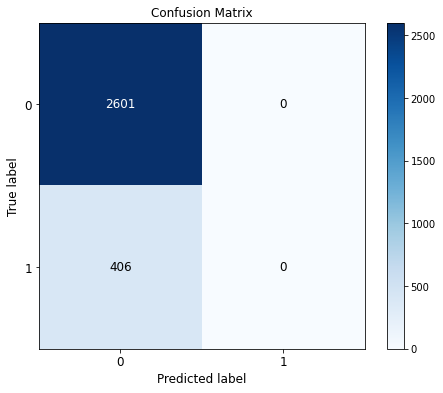

In [0]:
print('Default')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'default')# returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Default SMOTE
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.0,0.0,0.865,NaN,0.0,NaN,0.5


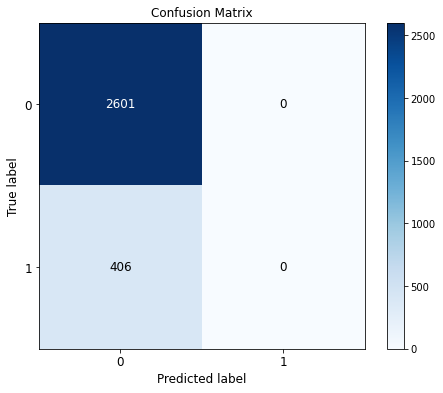

In [0]:
print('Default SMOTE')
print('------------------------------------------------------------')
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'default')# returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Logistic Regression
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.5887,0.4406,0.5634,0.1726,0.5887,0.2669,0.574035


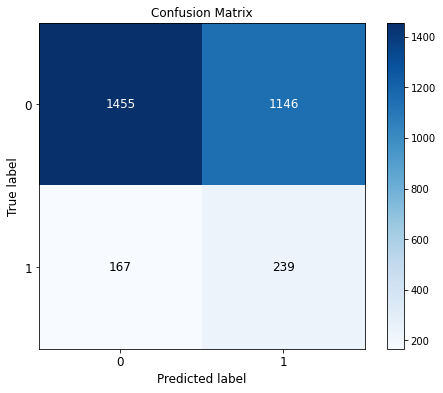

In [0]:
print('Logistic Regression')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'logreg')# returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Logistic Regression SMOTE
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.5887,0.4241,0.5777,0.1781,0.5887,0.2735,0.582301


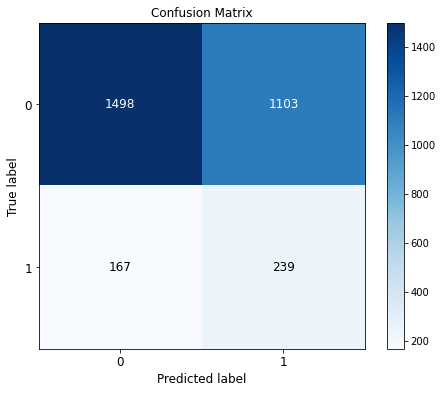

In [0]:
print('Logistic Regression SMOTE')
print('------------------------------------------------------------')
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'logreg')# returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Support Vector Machine
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.0,0.0,0.865,NaN,0.0,NaN,0.5


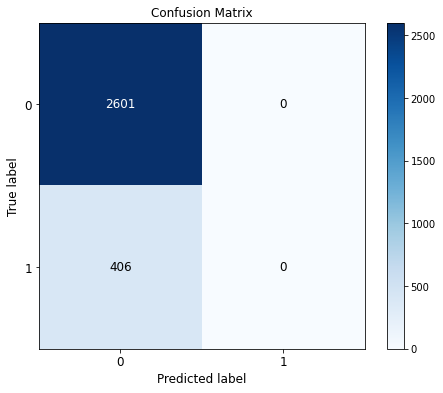

In [0]:
print('Support Vector Machine')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'svm')# returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Support Vector Machine SMOTE
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.2808,0.1557,0.7682,0.2197,0.2808,0.2465,0.562539


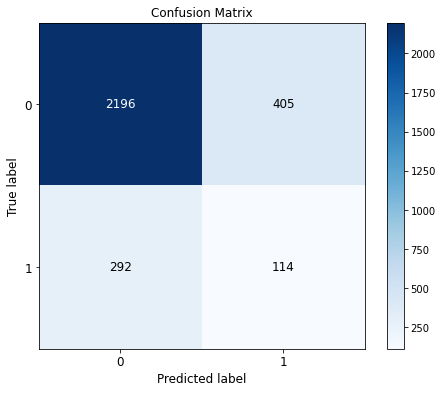

In [0]:
print('Support Vector Machine SMOTE')
print('------------------------------------------------------------')
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'svm')# returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Naieve Bayes
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.2463,0.2388,0.6917,0.1387,0.2463,0.1775,0.503776


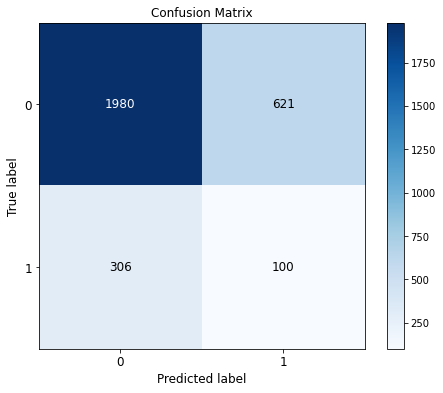

,prediction,true_output,fold
0,0.0011,0,1
1,0.0000,0,1
2,0.0004,0,1
3,0.4822,1,1
4,0.3033,0,1
...,...,...,...
3002,0.0029,0,5
3003,0.0328,0,5
3004,0.0008,0,5
3005,0.0001,0,5


In [0]:
print('Naieve Bayes')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'nb') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()
display(tmp)

Naieve Bayes SMOTE
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.6034,0.4833,0.5284,0.1631,0.6034,0.2568,0.560086


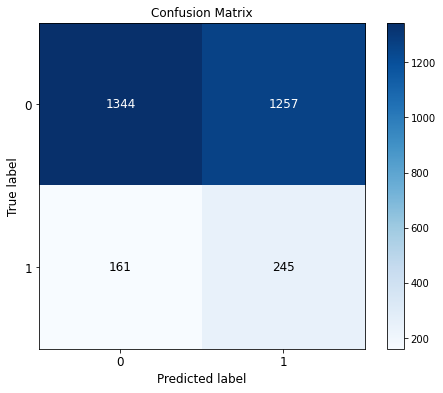

,prediction,true_output,fold
0,0.6117,0,1
1,0.3966,0,1
2,0.5336,0,1
3,0.6582,1,1
4,0.5921,0,1
...,...,...,...
3002,0.3532,0,5
3003,0.4497,0,5
3004,0.4875,0,5
3005,0.3988,0,5


In [0]:
print('Naieve Bayes SMOTE')
print('------------------------------------------------------------')
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'nb') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()
display(tmp)

Decision Tree
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.5739,0.3572,0.6335,0.2005,0.5739,0.2972,0.608361


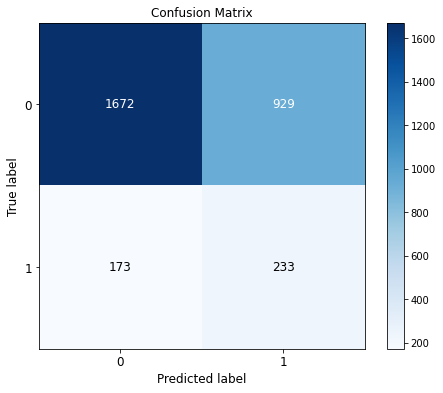

In [0]:
print('Decision Tree')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'dt') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Decision Tree SMOTE
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.4901,0.3922,0.592,0.1632,0.4901,0.2449,0.548995


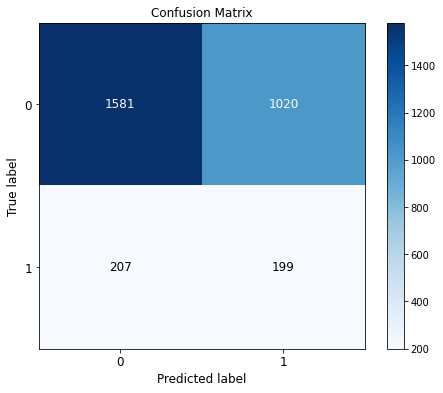

In [0]:
print('Decision Tree SMOTE')
print('------------------------------------------------------------')
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'dt') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Random Forest
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.3645,0.2272,0.7177,0.2003,0.3645,0.2585,0.568656


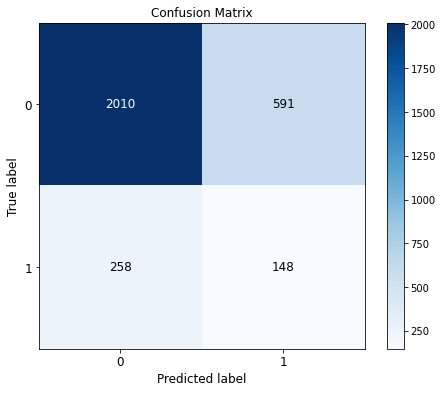

In [0]:
print('Random Forest')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'rfc') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

Random Forest SMOTE
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.4039,0.311,0.6505,0.1686,0.4039,0.2379,0.546453


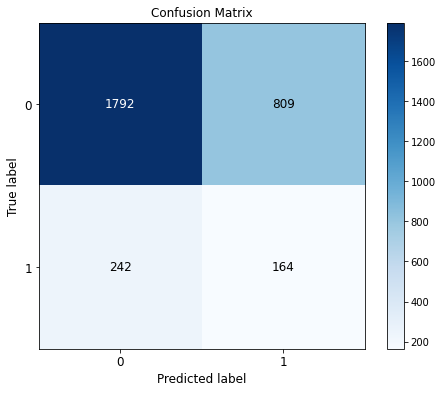

In [0]:
print('Random Forest SMOTE')
print('------------------------------------------------------------')
tmp = do_cv_class_great_smote(df_train_songs,df_train,7,'rfc') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

KNN
------------------------------------------------------------


,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.0222,0.0423,0.8314,0.0756,0.0222,0.0343,0.489938


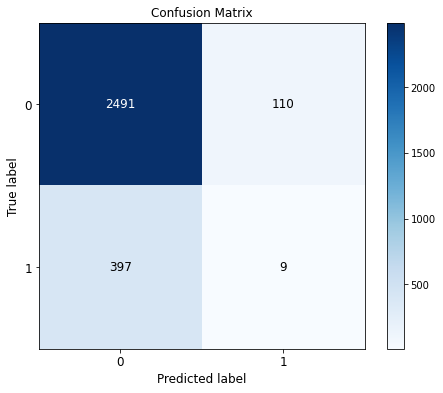

In [0]:
print('KNN')
print('------------------------------------------------------------')
tmp = do_cv_class_great(df_train_songs,df_train,7,'5nn') # returns pandas dataframe

display(get_metrics(tmp.iloc[:, 0:2]))

plt.show()

# ROC For All Models

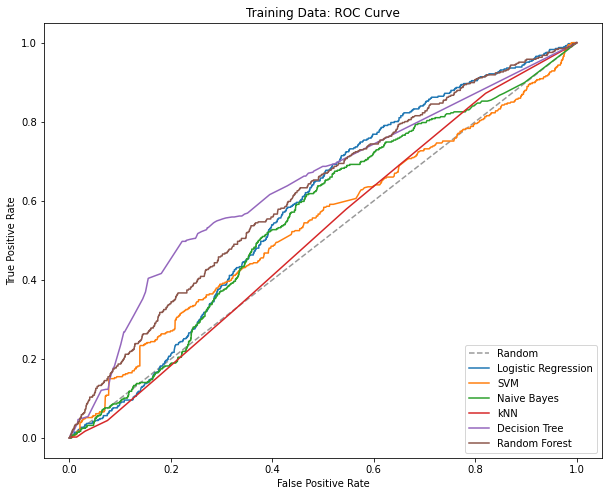

In [0]:
#Plotting an RO graph to using false postive and true postive rates to determine the best performing model
#Refernece: https://www.dezyre.com/recipes/plot-roc-curve-in-python

df_op1 = do_cv_class_great(df_train_songs,df_train,7,'logreg') # do_cv_class(df_scaledData,7,'logreg')
df_op2 = do_cv_class_great(df_train_songs,df_train,7,'svm') #do_cv_class(df_scaledData,7,'svm')
df_op3 = do_cv_class_great(df_train_songs,df_train,7,'nb') # do_cv_class(df_scaledData,7,'nb')
df_op4 = do_cv_class_great(df_train_songs,df_train,7,'15nn') # do_cv_class(df_scaledData,7,'15nn')
df_op5 = do_cv_class_great(df_train_songs,df_train,7,'dt') #do_cv_class(df_scaledData,7,'dt')
df_op6 = do_cv_class_great(df_train_songs,df_train,7,'rfc') #do_cv_class(df_scaledData,7,'rfc')

logreg_fpr, logreg_tpr, threshold1  = roc_curve(df_op1['true_output'], df_op1['prediction'])
svm_fpr, svm_tpr, threshold2 = roc_curve(df_op2['true_output'], df_op2['prediction'])
nb_fpr, nb_tpr, threshold3 = roc_curve(df_op3['true_output'], df_op3['prediction'])
knn_fpr, knn_tpr, threshold4 = roc_curve(df_op4['true_output'], df_op4['prediction'])

dt_fpr, dt_tpr, threshold5 = roc_curve(df_op5['true_output'], df_op5['prediction'])
rfc_fpr, rfc_tpr, threshold6 = roc_curve(df_op6['true_output'], df_op6['prediction'])

plt.figure(figsize=(10,8))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.plot(logreg_fpr, logreg_tpr, label ='Logistic Regression')
plt.plot(svm_fpr, svm_tpr, label ='SVM')
plt.plot(nb_fpr, nb_tpr, label = 'Naive Bayes')
plt.plot(knn_fpr, knn_tpr, label ='kNN')
plt.plot(dt_fpr, dt_tpr, label ='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label ='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Data: ROC Curve')
plt.legend(loc="lower right")
plt.show()

#ROC for SMOTE

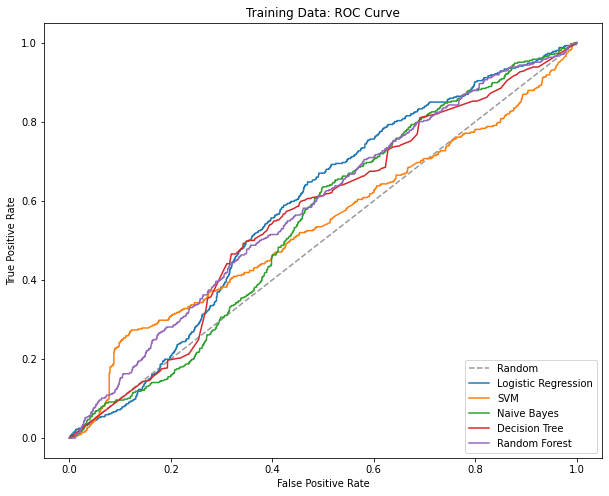

In [0]:
#Plotting an RO graph to using false postive and true postive rates to determine the best performing model
#Refernece: https://www.dezyre.com/recipes/plot-roc-curve-in-python

df_op1 = do_cv_class_great_smote(df_train_songs,df_train,7,'logreg') # do_cv_class(df_scaledData,7,'logreg')
df_op2 = do_cv_class_great_smote(df_train_songs,df_train,7,'svm') #do_cv_class(df_scaledData,7,'svm')
df_op3 = do_cv_class_great_smote(df_train_songs,df_train,7,'nb') # do_cv_class(df_scaledData,7,'nb')
# df_op4 = do_cv_class_great_smote(df_train_songs,df_train,7,'15nn') # do_cv_class(df_scaledData,7,'15nn')
df_op5 = do_cv_class_great_smote(df_train_songs,df_train,7,'dt') #do_cv_class(df_scaledData,7,'dt')
df_op6 = do_cv_class_great_smote(df_train_songs,df_train,7,'rfc') #do_cv_class(df_scaledData,7,'rfc')

logreg_fpr, logreg_tpr, threshold1  = roc_curve(df_op1['true_output'], df_op1['prediction'])
svm_fpr, svm_tpr, threshold2 = roc_curve(df_op2['true_output'], df_op2['prediction'])
nb_fpr, nb_tpr, threshold3 = roc_curve(df_op3['true_output'], df_op3['prediction'])
# knn_fpr, knn_tpr, threshold4 = roc_curve(df_op4['true_output'], df_op4['prediction'])

dt_fpr, dt_tpr, threshold5 = roc_curve(df_op5['true_output'], df_op5['prediction'])
rfc_fpr, rfc_tpr, threshold6 = roc_curve(df_op6['true_output'], df_op6['prediction'])

plt.figure(figsize=(10,8))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.plot(logreg_fpr, logreg_tpr, label ='Logistic Regression')
plt.plot(svm_fpr, svm_tpr, label ='SVM')
plt.plot(nb_fpr, nb_tpr, label = 'Naive Bayes')
# plt.plot(knn_fpr, knn_tpr, label ='kNN')
plt.plot(dt_fpr, dt_tpr, label ='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label ='Random Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Data: ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
df_train.head()

,Unnamed: 0,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Text,track_id,user_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,freq_song,status
0,0,0.0000,0.0000,0.7917,0.0,0.0000,0.1129,0.0241,0.0000,0.0000,0.0691,know know know know one one one one one never ...,TRAALAH128E078234A,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Bitter Sweet Symphony,SOXQYSC12A6310E908,Bitter Sweet Symphony,AR0L04E1187B9AE90C,d4d17620-fd97-4574-92a8-a2cb7e72ce42,The Verve,360.25424,0.767730,0.587810,1997,9634,-1,0,0.0,0
465,465,0.1230,0.1465,0.0000,0.0,0.2287,0.0000,0.0000,0.0000,0.0000,0.4967,know come come come go go go go go oh oh never...,TRENTGL128E0780C8E,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Clocks,SOCVTLJ12A6310F0FD,A Rush Of Blood To The Head,ARJ7KF01187B98D717,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,307.51302,0.865022,0.916053,2002,2971,-1,0,0.0,0
2418,2418,0.0536,0.0000,0.0000,0.0,0.0000,0.8667,0.0000,0.0000,0.0737,0.0000,know know know know come come come come oh oh ...,TRWQQVW128F422AECF,01047b99e00bb0743f66bb321bdd62e38fddb0a5,The Funeral (Album Version),SOEQJBS12A8AE475A4,The Road Mix: Music From The Television Series...,ARIUYZD1187FB59892,07b6020a-c539-4d68-aeef-f159f3befc76,Band Of Horses,321.14893,0.767081,0.593106,0,2572212,-1,0,0.0,0
93,93,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.9867,0.0000,oh one one yeah yeah yeah yeah yeah yeah yeah ...,TRBGCAK128F425F3CC,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Firestarter,SOHHJYE12A8AE47599,Put Your Hands Up! 4,AR4L4WQ1187FB51996,4a4ee089-93b1-4470-af9a-6ff575d32704,The Prodigy,225.09669,0.638614,0.601436,1996,3127217,6507,6507,0.0,0
2790,2790,0.5562,0.0974,0.0000,0.0,0.0000,0.0573,0.0375,0.0876,0.0000,0.1624,know know go one get get get get see let let l...,TRZGABY128F1462E00,01047b99e00bb0743f66bb321bdd62e38fddb0a5,Ocean Avenue,SOKQZYZ12A58A7767E,Ocean Avenue,AR048JZ1187B9AEB85,3630fff3-52fc-4e97-ab01-d68fd88e4135,Yellowcard,198.32118,0.872934,0.627467,2003,285605,-1,0,0.0,0


#SMOTE
Oversampling


In [0]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.under_sampling import NearMiss

df_train = userProfileGen(df_train)
df_train=df_train.sort_values(by=['user_id'])
df_train = df_train[['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
'artist_id', 'artist_name', 'duration', 'artist_familiarity',
'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
'user_feature_0','user_feature_1', 'user_feature_2', 'user_feature_3', 'user_feature_4',
'user_feature_5', 'user_feature_6', 'user_feature_7', 'user_feature_8',
'user_feature_9', 'user_feature_10', 'user_feature_11',
'user_feature_12', 'status']]
df_test=addUserProfile(df_train,df_test)
df_test=df_test.sort_values(by=['user_id'])
df_test = df_test[['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
'artist_id', 'artist_name', 'duration', 'artist_familiarity',
'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
'user_feature_0','user_feature_1', 'user_feature_2', 'user_feature_3', 'user_feature_4',
'user_feature_5', 'user_feature_6', 'user_feature_7', 'user_feature_8',
'user_feature_9', 'user_feature_10', 'user_feature_11',
'user_feature_12', 'status']]
df_train = df_train.set_index(['user_id', 'track_id', 'title', 'song_id', 'year', 'release','artist_id', 'artist_name',])
df_test = df_test.set_index(['user_id', 'track_id', 'title', 'song_id','year','release','artist_id', 'artist_name'])

# model1 = LogisticRegression(class_weight='balanced',max_iter= 100 , penalty= 'l2')  
model1= DecisionTreeClassifier(max_leaf_nodes = 100, min_samples_split= 3,class_weight= 'balanced',max_features = 'auto', random_state = 560)
X_train = df_train.iloc[:,:-1]# get training input data
y_train = df_train.iloc[:,-1]# get training output data
model1.fit(X_train,y_train)  
# model2.fit(X_train,y_train)

# print(f'Accuracy: {model.score(X_test, y_test)}')
# print(f'f-score: {classification_report(y_test, y_pred)}')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=560, splitter='best')

In [0]:
display(model1.feature_importances_)

array([0.13069679, 0.0793724 , 0.09303072, 0.01088789, 0.02231802,
       0.0082708 , 0.0103538 , 0.        , 0.09091677, 0.01438655,
       0.01033076, 0.00958774, 0.18079337, 0.02492587, 0.01683506,
       0.02613966, 0.02482409, 0.01400438, 0.05192399, 0.02601485,
       0.02408992, 0.03556709, 0.02287542, 0.01998217, 0.02113751,
       0.0307344 ])

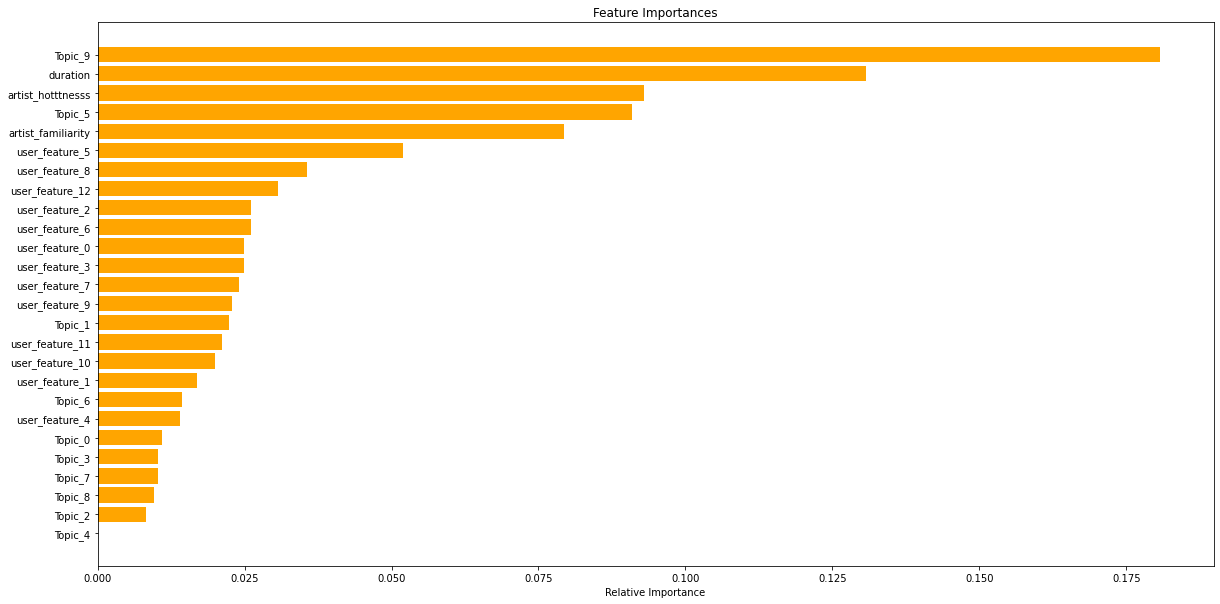

In [0]:
features = X_train.columns
importances = model1.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#TEST Data

In [0]:
df_test.head()

duration  ...  status
user_id                                  track_id           title          song_id            year release                         artist_id          artist_name                                 ...        
01047b99e00bb0743f66bb321bdd62e38fddb0a5 TRABFDT12903CADD73 Up Up & Away   SOARUPP12AB01842E0 2009 Man On The Moon: The End Of Day ARD46C811C8A414F3F Kid Cudi                         227.34322  ...       1
                                         TRVSRJL128F14976B6 Hips Don't Lie SOEHWGF12A6D4F8B2B 2006 Hitzone 38                      AR6PJ8R1187FB5AD70 Shakira ft. Wyclef Jean          215.90159  ...       0
                                         TRCLXTI128F932D0C9 One Time       SODOWUC12AC9097E76 2009 One Time                        ARFCWSZ123526A0AFD Justin Bieber                    214.67383  ...       1
                                         TRMEQQX12903CCD9D5 Eenie Meenie   SOGSAYQ12AB018BA14 0    Eenie Meenie                    AR9LJ9D1187FB4303D Sean Kingston and Justin Bieber  201.95220  ...       1
                                         TRQFXKD128E0780CAE The Scientist  SOKLRPJ12A8C13C3FE 2002 The Scientist                   ARJ7KF01187B98D717 Coldplay                         311.27465  ...       0

[5 rows x 27 columns]

In [0]:
def probToBinary(data,threshold=0.5):
        binary=data.apply(lambda x: 1 if x['prediction']>=threshold else 0,axis=1)
        data['prediction']=binary

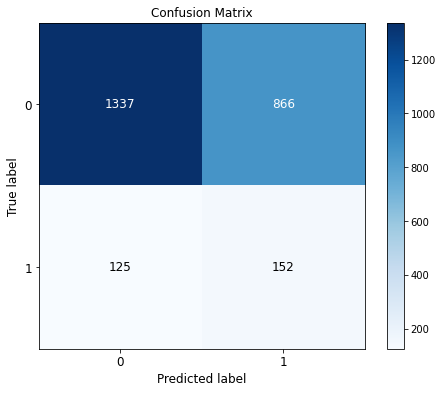

,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.5487,0.3931,0.6004,0.1493,0.5487,0.2347,0.577818


              precision    recall  f1-score   support

           0       0.91      0.61      0.73      2203
           1       0.15      0.55      0.23       277

    accuracy                           0.60      2480
   macro avg       0.53      0.58      0.48      2480
weighted avg       0.83      0.60      0.67      2480



In [0]:
df_test_X = df_test.iloc[:,:-1]# get training input data
df_test_Y = df_test.iloc[:,-1]# get training output data

# Predict probability on the test data: y_pred
prob_pred = model1.predict_proba(df_test_X)
y_pred_prob = [np.round((prob_pred[i][1]),4) for i in range(len(prob_pred))]

y_pred = model1.predict(df_test_X)
tn, fp, fn, tp = confusion_matrix(df_test_Y.values, y_pred, labels=[0,1]).ravel()
skplt.metrics.plot_confusion_matrix(df_test_Y.values, y_pred, figsize=(8,6), text_fontsize='large')
plt.show()
fpr, tpr, t = roc_curve(df_test_Y.values,y_pred)
roc_auc = auc(fpr, tpr)
precision = np.round([(tp / (tp + fp))],4),
recall = np.round([(tp/(tp + fn))],4)
f1Score = np.round((2*((precision * recall)/(precision + recall))),4)

output = { 'TPR' : np.round([(tp/(tp + fn))],4),
          'FPR' : np.round([(fp / (tn + fp))],4),
          'Accuracy' : np.round([((tp + tn) / (tn + fp + fn + tp))],4),
          'Precision' : np.round([(tp / (tp + fp))],4),
          'Recall' : np.round([(tp/(tp + fn))],4),
          'F1' : f1Score[0][0],
          'AUC':roc_auc
        }

df_metric = pd.DataFrame(output)
display(df_metric)
print(classification_report(df_test_Y, y_pred))
df_test['pred']=y_pred
df_test['pred_prob']=y_pred_prob

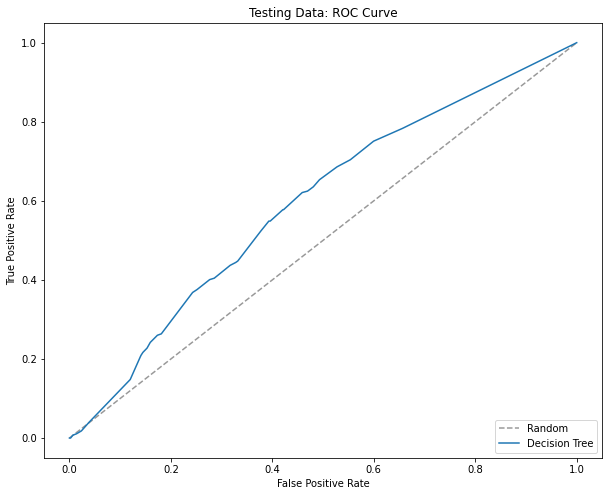

In [0]:
rfc_fpr1, rfc_tpr1, threshold6 = roc_curve(df_test_Y.values, y_pred_prob)

plt.figure(figsize=(10,8))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.plot(rfc_fpr1, rfc_tpr1, label ='Decision Tree')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Data: ROC Curve')
plt.legend(loc="lower right")
plt.show()

#SetThreshold

In [0]:
def probToBinary(data,threshold=0.5):
        binary=data.apply(lambda x: 1 if x['pred_prob']>=threshold else 0,axis=1)
        data['prediction']=binary
        return data

#Recommendation 

In [0]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
probToBinary(df_test,0.35)

duration  ...  prediction
user_id                                  track_id           title           song_id            year release                         artist_id          artist_name                                 ...            
01047b99e00bb0743f66bb321bdd62e38fddb0a5 TRABFDT12903CADD73 Up Up & Away    SOARUPP12AB01842E0 2009 Man On The Moon: The End Of Day ARD46C811C8A414F3F Kid Cudi                         227.34322  ...           1
                                         TRVSRJL128F14976B6 Hips Don't Lie  SOEHWGF12A6D4F8B2B 2006 Hitzone 38                      AR6PJ8R1187FB5AD70 Shakira ft. Wyclef Jean          215.90159  ...           0
                                         TRCLXTI128F932D0C9 One Time        SODOWUC12AC9097E76 2009 One Time                        ARFCWSZ123526A0AFD Justin Bieber                    214.67383  ...           1
                                         TRMEQQX12903CCD9D5 Eenie Meenie    SOGSAYQ12AB018BA14 0    Eenie Meenie                    AR9LJ9D1187FB4303D Sean Kingston and Justin Bieber  201.95220  ...           1
                                         TRQFXKD128E0780CAE The Scientist   SOKLRPJ12A8C13C3FE 2002 The Scientist                   ARJ7KF01187B98D717 Coldplay                         311.27465  ...           1
...                                                                                                                                                                                           ...  ...         ...
fd9f6c7bfa29d9f513f6a4114dfca7198866a9a7 TRFDCPI128F93234B7 The Climb       SOUKMKR12A8C141925 2009 Hannah Montana The Movie        ARYAVBS1187FB5B46C Miley Cyrus                      236.85179  ...           0
                                         TRFQOSP128F427C2B2 Canada          SOPUCYA12A8C13A694 0    The End Is Here                 AR2W94J1187B9B5C2C Five Iron Frenzy                 236.09424  ...           0
                                         TRFUVKB12903CB0FE3 Smooth Criminal SOOCKPO12A67021D10 2001 Teenage dirtbag                 ARO6A7Q1187FB4CFC4 Alien Ant Farm                   209.39710  ...           0
                                         TREQNRF12903CF2405 Drop The World  SOUVTSM12AC468F6A7 0    Drop The World                  ARUDYKB11F4C83C269 Lil Wayne / Eminem               229.58975  ...           0
                                         TRZYAGJ128F9332CEF Favorite Girl   SOZEETS12AC9071BD3 2009 My World                        ARFCWSZ123526A0AFD Justin Bieber                    256.78322  ...           0

[2480 rows x 30 columns]

              precision    recall  f1-score   support

           0       0.92      0.54      0.68      2203
           1       0.15      0.62      0.24       277

    accuracy                           0.55      2480
   macro avg       0.53      0.58      0.46      2480
weighted avg       0.83      0.55      0.63      2480



,TPR,FPR,Accuracy,Precision,Recall,F1,AUC
0,0.6209,0.4589,0.55,0.1454,0.6209,0.2356,0.581009


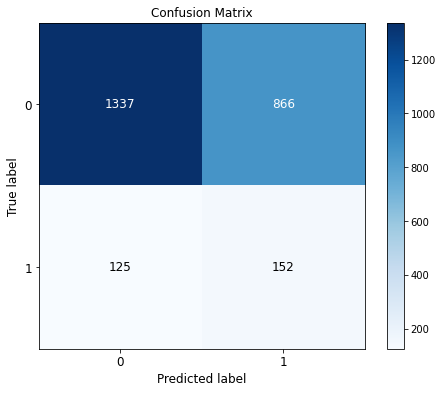

In [0]:
tn, fp, fn, tp = confusion_matrix(df_test['status'].values, df_test['prediction'].values, labels=[0,1]).ravel()
skplt.metrics.plot_confusion_matrix(df_test_Y.values, y_pred, figsize=(8,6), text_fontsize='large')
print(classification_report(df_test['status'].values,df_test['prediction'].values))
fpr, tpr, t = roc_curve(df_test['status'].values,df_test['prediction'].values)
roc_auc = auc(fpr, tpr)
precision = np.round([(tp / (tp + fp))],4),
recall = np.round([(tp/(tp + fn))],4)
f1Score = np.round((2*((precision * recall)/(precision + recall))),4)

output = { 'TPR' : np.round([(tp/(tp + fn))],4),
          'FPR' : np.round([(fp / (tn + fp))],4),
          'Accuracy' : np.round([((tp + tn) / (tn + fp + fn + tp))],4),
          'Precision' : np.round([(tp / (tp + fp))],4),
          'Recall' : np.round([(tp/(tp + fn))],4),
          'F1' : f1Score[0][0],
          'AUC':roc_auc
        }

df_metric = pd.DataFrame(output)
display(df_metric)

In [0]:
df_test=df_test.reset_index()

In [0]:
df_test['prediction'].value_counts()

0    1297
1    1183
Name: prediction, dtype: int64

In [0]:
df_test.columns

Index(['user_id', 'track_id', 'title', 'song_id', 'year', 'release',
       'artist_id', 'artist_name', 'duration', 'artist_familiarity',
       'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
       'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9',
       'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3',
       'user_feature_4', 'user_feature_5', 'user_feature_6', 'user_feature_7',
       'user_feature_8', 'user_feature_9', 'user_feature_10',
       'user_feature_11', 'user_feature_12', 'status', 'pred', 'pred_prob',
       'prediction'],
      dtype='object')

In [0]:
df_song_features=df_test.loc[:,['user_id','song_id','duration', 'artist_familiarity',
       'artist_hotttnesss', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3',
       'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9','status','pred', 'pred_prob','prediction']]

In [0]:
df_user_features=df_test.loc[:,['user_id','user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3',
       'user_feature_4', 'user_feature_5', 'user_feature_6', 'user_feature_7',
       'user_feature_8', 'user_feature_9', 'user_feature_10',
       'user_feature_11', 'user_feature_12']]

In [0]:
df_user_features=df_user_features.drop_duplicates()

In [0]:
df_user_features.head()

,user_id,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9,user_feature_10,user_feature_11,user_feature_12
0,01047b99e00bb0743f66bb321bdd62e38fddb0a5,237.095144,0.746933,0.745281,0.067642,0.002663,0.040868,0.001421,0.079816,0.201837,0.096595,0.062463,0.016237,0.425542
80,126ee2cc7dfb9bfb8e831633a5443a9b2b7490c0,210.646176,0.781376,0.670363,0.134793,0.150294,0.005680,0.032034,0.078690,0.267876,0.036297,0.027154,0.094910,0.166576
160,1b8c08ef0705ff5b9329c175904e3c48d8f6b116,238.541043,0.740103,0.752005,0.013678,0.010183,0.000700,0.000750,0.104856,0.294817,0.104583,0.005228,0.033028,0.426639
240,206bd0676fe110325996506f393538fbf422549e,239.455584,0.889228,0.730277,0.231224,0.011500,0.002750,0.000000,0.071318,0.307782,0.018435,0.001618,0.094729,0.256503
320,291a37c97bedabb862b2f6bad7f439cf72123d84,265.714131,0.791908,0.660914,0.004573,0.139118,0.156216,0.063736,0.007761,0.093984,0.151455,0.018618,0.117070,0.238666


In [0]:
vect1=df_user_features[df_user_features['user_id']=='01047b99e00bb0743f66bb321bdd62e38fddb0a5']
vect1=vect1.iloc[:,1:].values

In [0]:
vect1

array([[2.37095144e+02, 7.46932999e-01, 7.45280986e-01, 6.76421045e-02,
        2.66315788e-03, 4.08684219e-02, 1.42105267e-03, 7.98157893e-02,
        2.01836844e-01, 9.65947383e-02, 6.24631569e-02, 1.62368417e-02,
        4.25542101e-01]])

In [0]:
blah=df_song_features[df_song_features['user_id']=='01047b99e00bb0743f66bb321bdd62e38fddb0a5']
blah.head()

,user_id,song_id,duration,artist_familiarity,artist_hotttnesss,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,status,pred,pred_prob,prediction
0,01047b99e00bb0743f66bb321bdd62e38fddb0a5,SOARUPP12AB01842E0,227.34322,0.808767,0.796314,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.9974,0.0000,1,1,0.6701,1
1,01047b99e00bb0743f66bb321bdd62e38fddb0a5,SOEHWGF12A6D4F8B2B,215.90159,0.833179,0.804220,0.0000,0.0809,0.0108,0.3288,0.0451,0.0000,0.1049,0.000,0.0000,0.4283,0,0,0.0000,0
2,01047b99e00bb0743f66bb321bdd62e38fddb0a5,SODOWUC12AC9097E76,214.67383,0.839406,0.691249,0.0000,0.0000,0.0000,0.0000,0.0000,0.9977,0.0000,0.000,0.0000,0.0000,1,1,0.5370,1
3,01047b99e00bb0743f66bb321bdd62e38fddb0a5,SOGSAYQ12AB018BA14,201.95220,0.925192,0.662876,0.0000,0.0000,0.0000,0.0000,0.0000,0.9971,0.0000,0.000,0.0000,0.0000,1,1,0.5370,1
4,01047b99e00bb0743f66bb321bdd62e38fddb0a5,SOKLRPJ12A8C13C3FE,311.27465,0.865022,0.916053,0.0468,0.0000,0.0000,0.0000,0.0000,0.3302,0.0000,0.619,0.0000,0.0000,0,1,0.5767,1


In [0]:
rows=[]
for i,j in blah.iterrows():
  vect2=j.iloc[2:-4].values
  cos_lib = cosine_similarity(vect1.reshape(1, -1), vect2.reshape(1, -1))
  j['cosine']=cos_lib[0][0]
  rows.append(j)

In [0]:
recommed_df=pd.DataFrame(rows)
display(recommed_df.sort_values(by=['pred_prob'],ascending=False,inplace=True))


None

In [0]:
df_test_songs.head()

,Unnamed: 0,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Text,track_id,user_id,song_id,freq_song,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.9974,0.0000,like like come come come one one one one one o...,TRABFDT12903CADD73,01047b99e00bb0743f66bb321bdd62e38fddb0a5,SOARUPP12AB01842E0,1,Up Up & Away,Man On The Moon: The End Of Day,ARD46C811C8A414F3F,e0e1db18-f7ba-4dee-95ff-7ae8cf545460,Kid Cudi,227.34322,0.808767,0.796314,2009,6394026,-1,0
1,1,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.9974,0.0000,like like come come come one one one one one o...,TRABFDT12903CADD73,4fdc19eb167382becbb84a069ddc20bfe5441a77,SOARUPP12AB01842E0,2,Up Up & Away,Man On The Moon: The End Of Day,ARD46C811C8A414F3F,e0e1db18-f7ba-4dee-95ff-7ae8cf545460,Kid Cudi,227.34322,0.808767,0.796314,2009,6394026,-1,0
2,2,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.9974,0.0000,like like come come come one one one one one o...,TRABFDT12903CADD73,b2084be1b2af9e87342c4f50afc38aa60262e143,SOARUPP12AB01842E0,2,Up Up & Away,Man On The Moon: The End Of Day,ARD46C811C8A414F3F,e0e1db18-f7ba-4dee-95ff-7ae8cf545460,Kid Cudi,227.34322,0.808767,0.796314,2009,6394026,-1,0
3,3,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.9974,0.0000,like like come come come one one one one one o...,TRABFDT12903CADD73,e56659bbda96724692232f0118715bca6bc39af1,SOARUPP12AB01842E0,2,Up Up & Away,Man On The Moon: The End Of Day,ARD46C811C8A414F3F,e0e1db18-f7ba-4dee-95ff-7ae8cf545460,Kid Cudi,227.34322,0.808767,0.796314,2009,6394026,-1,0
4,4,0.0,0.0,0.0,0.0,0.7252,0.0,0.0,0.0,0.0000,0.2723,know know know know like like like like like l...,TRAFQFV128F9326217,b2084be1b2af9e87342c4f50afc38aa60262e143,SOYDHXP12AB01849D4,1,Good Life,Waking Up,AR73S4G1187B9A03C2,c33c2065-b1c3-4406-b066-d33a9e2ea71a,OneRepublic,253.25669,0.744410,0.792048,2009,7001805,-1,0


In [0]:
def reccommend_user(user,n):
  print("Generating Recommendations for User ",user)
  print("---------------------------------------------")
  vect1=df_user_features[df_user_features['user_id']==user]
  vect1=vect1.iloc[:,1:].values
  blah=df_song_features[df_song_features['user_id']==user]
  blah.head()
  rows=[]
  for i,j in blah.iterrows():
    vect2=j.iloc[2:-4].values
    cos_lib = cosine_similarity(vect1.reshape(1, -1), vect2.reshape(1, -1))
    j['cosine']=cos_lib[0][0]
    rows.append(j)
  recommed_df=pd.DataFrame(rows)
  recommed_df.sort_values(by=['prediction'],ascending=False,inplace=True)
  for i,j in recommed_df.iloc[:n,:].iterrows():
    temp=df_test_songs[df_test_songs['song_id']==j['song_id']]
    print(temp['title'].values[0],'by',temp['artist_name'].values[0])  
  print("---------------------------------------------")
  print("User Listens to ",recommed_df.iloc[:n,-5].sum(),"out of ",n,"songs")
  print("**********************************************")
  return recommed_df.iloc[:n,-5].sum()

In [0]:
reccommend_user('01047b99e00bb0743f66bb321bdd62e38fddb0a5',5)

Generating Recommendations for User  01047b99e00bb0743f66bb321bdd62e38fddb0a5
---------------------------------------------
Up Up & Away by Kid Cudi
Oxford Comma (Album) by Vampire Weekend
You Belong With Me by Taylor Swift
Drop The World by Lil Wayne / Eminem
Make Love To Your Mind by Bill Withers
---------------------------------------------
User Listens to  2 out of  5 songs
**********************************************


2

In [0]:
songs_actual=[]
for user in df_user_features['user_id'].unique():
  songs_actual.append(reccommend_user(user,5))

Generating Recommendations for User  01047b99e00bb0743f66bb321bdd62e38fddb0a5
---------------------------------------------
Up Up & Away by Kid Cudi
Oxford Comma (Album) by Vampire Weekend
You Belong With Me by Taylor Swift
Drop The World by Lil Wayne / Eminem
Make Love To Your Mind by Bill Withers
---------------------------------------------
User Listens to  2 out of  5 songs
**********************************************
Generating Recommendations for User  126ee2cc7dfb9bfb8e831633a5443a9b2b7490c0
---------------------------------------------
Love Me by Justin Bieber
Drops Of Jupiter by Train
Gente Que No by Los Auténticos Decadentes
Tighten Up by The Black Keys
Sparks by Coldplay
---------------------------------------------
User Listens to  0 out of  5 songs
**********************************************
Generating Recommendations for User  1b8c08ef0705ff5b9329c175904e3c48d8f6b116
---------------------------------------------
One Time by Justin Bieber
Creep (Explicit) by Radiohead

In [0]:
print(sum(songs_actual)/(len(songs_actual)*5))

0.14838709677419354
